Playing SET
---
[keras on actor-critic](https://keras.io/examples/rl/actor_critic_cartpole/)

[tensorflow docs on actor-critic](https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic)

Encode cards with 2 bits per feature.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


import gym
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:29: DeprecationWarning: Call to deprecated create function Descriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _TENSORSHAPEPROTO_

In [2]:
tf.version

<module 'tensorflow._api.v2.version' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>

In [3]:
#two bits are needed to store the three options
columns = [
    'number 1',
    'number 2',
    'color 1',
    'color 2',
    'symbol 1',
    'symbol 2',
    'texture 1',
    'texture 2'
]

# a feature can be one of three 
feature_options = [
    '10', #this
    '01', #that
    '00' #other
]

#make encoded card data
cards_list = np.array([
    [
        [
            [
                [
                    character
                    for character in numberoption+coloroption+symboloption+textureoption
                ]
                for textureoption in feature_options
            ]
            for symboloption in feature_options
        ]
        for coloroption in feature_options
    ]
    for numberoption in feature_options
])
cards_list = cards_list.reshape(81,8)
cards_list.shape

(81, 8)

In [4]:
#encode each card as a row in a dataframe with 1-bit columns
bit_cards = pd.DataFrame(cards_list, columns = columns).astype(int).astype(bool) #can't tell the difference between '1' and '0' until it's been turned to int
bit_cards.index.name = 'card index'
bit_cards.head()

,number 1,number 2,color 1,color 2,symbol 1,symbol 2,texture 1,texture 2
card index,,,,,,,,
0,True,False,True,False,True,False,True,False
1,True,False,True,False,True,False,False,True
2,True,False,True,False,True,False,False,False
3,True,False,True,False,False,True,True,False
4,True,False,True,False,False,True,False,True


In [5]:
#encode each card as a row in a dataframe with 2-bit columns
columns = [
    'number',
    'color',
    'symbol',
    'texture'
]

feature_options = 'abc'

cards_list = np.array([
    [
        [
            [
                [numberoption, coloroption, symboloption, textureoption]
                for textureoption in feature_options
            ]
            for symboloption in feature_options
        ]
        for coloroption in feature_options
    ]
    for numberoption in feature_options
]).reshape(81,4)

cards = pd.DataFrame(cards_list, columns = columns)

In [6]:
cards.head(), cards.tail()

(  number color symbol texture
 0      a     a      a       a
 1      a     a      a       b
 2      a     a      a       c
 3      a     a      b       a
 4      a     a      b       b,
    number color symbol texture
 76      c     c      b       b
 77      c     c      b       c
 78      c     c      c       a
 79      c     c      c       b
 80      c     c      c       c)

In [7]:
# determine if three cards are a set


#checks if the feature value for three series is all the same thing

def all_same(series1, series2, series3, feature):
    return series1[feature] == series2[feature] and series2[feature] == series3[feature]

#checks if the feature values for three series are all unique

def all_diffnt(series1, series2, series3, feature):
    return series1[feature] != series2[feature] and series2[feature] != series3[feature] and series3[feature] != series1[feature]
    
    
#gives True if the three cards are a set, False if not
#feed this a pd.Series of the 4 features

def setQ(card_list):
    card1, card2, card3 = card_list
    #assumes the cards are a set at the outset. Will turn to False if it fails any of the tests.
    setA = True
    features = ['number','color','symbol','texture']
    for feature in features:
        feature_check = all_same(card1, card2, card3, feature) or all_diffnt(card1,card2,card3,feature)
        setA = setA and feature_check
    return setA
            

In [8]:
#are the first three cards a set?
setQ([cards.loc[0],cards.loc[1],cards.loc[2]])

True

In [9]:
#are the first two and the fourth a set?
setQ([cards.loc[0],cards.loc[1],cards.loc[3]])

False

In [10]:
#convert a 2-bit encoded card into a 3-bit card.

def two_to_three_bits(two_bit_series):
    two_bit_columns = [
    'number 1',
    'number 2',
    'color 1',
    'color 2',
    'symbol 1',
    'symbol 2',
    'texture 1',
    'texture 2'
    ]
    three_bit_columns = [
    'number',
    'color',
    'symbol',
    'texture'
    ]
    three_bit_series = pd.Series(dtype='object', index = three_bit_columns)
    for column in three_bit_columns:
        if two_bit_series[column + ' 1']:
            this_value = 'a'
        elif two_bit_series[column + ' 2']:
            this_value = 'b'
        else:
            this_value = 'c'
        three_bit_series[column] = this_value
    return three_bit_series

def index_to_series_list(index_list):
    return [
        cards.loc[index]
        for index in index_list
    ]

In [11]:
#encode the first two-bit card as a three-bit
two_to_three_bits(bit_cards.loc[0])

number     a
color      a
symbol     a
texture    a
dtype: object

In [12]:
#two-bit cards are easier to feed to a model.

actor-critic model
---

the model will be fed `8*12 == 96` bits corresponding to twelve cards data. It then will give a set of cards to take as well as a prediction of whether it

In [13]:
rng_seed = 2022
rng = np.random.default_rng(rng_seed)

In [14]:
rng.choice(range(81), 3, replace = False)

array([19, 60, 55])

In [15]:
#splits a deck into cards on the board and cards left in the deck.
def initialize_board(num_cards, board_size, rng):
    card_list = list(range(num_cards))
    board = rng.choice(card_list, board_size, replace = False)
    card_list = np.array([
        card
        for card in card_list
        if card not in board
    ])
    return board, card_list

#takes a board, a deck, and draws up to the board size.
# returns a new board with added cards and the deck with those
#cards removed.
def draw_cards(board, deck, rng, board_size = 12, p = None):
    num_cards_to_draw = board_size - len(board)
    if len(board) + len(deck) < board_size:
        print(f'{num_cards_to_draw} cards are needed to complete the board, but only {len(card_list)} remain in the deck.' )
        return None
    else:
        drawn_cards = rng.choice(deck, num_cards_to_draw, replace = False, p = p)
        new_deck = list(deck)
        for card in drawn_cards:
            new_deck.remove(card)
        new_deck = np.array(new_deck)
        new_board = np.concatenate([board, drawn_cards])
        return new_board, new_deck

In [16]:
#initialize a game
board, deck = initialize_board(81,12,np.random.default_rng(2022))
board, deck

(array([ 6,  4, 71, 69, 13, 61, 53,  5, 49, 45, 17, 52]),
 array([ 0,  1,  2,  3,  7,  8,  9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21,
        22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
        39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 51, 54, 55, 56, 57, 58, 59,
        60, 62, 63, 64, 65, 66, 67, 68, 70, 72, 73, 74, 75, 76, 77, 78, 79,
        80]))

In [17]:
#test out drawing cards. this doesn't replace the originals.
draw_cards(board[:6],deck,rng)

(array([ 6,  4, 71, 69, 13, 61,  7, 78, 72, 44, 70, 51]),
 array([ 0,  1,  2,  3,  8,  9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 22,
        23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
        40, 41, 42, 43, 46, 47, 48, 50, 54, 55, 56, 57, 58, 59, 60, 62, 63,
        64, 65, 66, 67, 68, 73, 74, 75, 76, 77, 79, 80]))

In [18]:
#takes an iterable of cards by index and returns a flat array of the card bits
def board_to_input(card_indices):
    model_input = bit_cards.loc[card_indices].astype(int).values.flatten()
    model_input = tf.convert_to_tensor(model_input)
    model_input = tf.expand_dims(model_input, 0)
    return model_input

In [19]:
board

array([ 6,  4, 71, 69, 13, 61, 53,  5, 49, 45, 17, 52])

In [20]:
sample_input = board_to_input(board)
sample_input

<tf.Tensor: shape=(1, 96), dtype=int32, numpy=
array([[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1]])>

In [21]:
#input should be the number of cards on the board (12) times the number of bits in a card (8).
len(sample_input) == 96

False

In [22]:
tf.convert_to_tensor(board_to_input(board))

<tf.Tensor: shape=(1, 96), dtype=int32, numpy=
array([[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1]])>

In [23]:
import logging

In [44]:
%%time

tf.get_logger().setLevel(logging.ERROR)
#prevents division by 0 (I think)
eps = np.finfo(np.float32).eps.item()

#boot up rng
rng_seed = 2022
rng = np.random.default_rng(rng_seed)

#discount factor for previous rewards
gamma = 0.995

# play 21 rounds. Maximum number is 81/3 -  a few for not having any sets remaining on the board. Minimum (81-12)/=69/3 = 21 rounds
rounds_per_game = 21

num_inputs = 8*12 #12 cards at a time, 8 bits per card
num_hidden = 256
board_size = 12 #cards per round

#build model
inputs = layers.Input(shape = (num_inputs,))
common_1 = layers.Dense(num_hidden, activation = 'relu', )(inputs)
common_2 = layers.Dense(num_hidden, activation = 'relu', )(common_1)
picks = layers.Dense(board_size, activation = 'softmax')(common_2)
critic = layers.Dense(1)(common_2)
model = keras.Model(inputs = inputs, outputs = [picks, critic])

#make optimizer
optimizer = keras.optimizers.Adam(learning_rate = 0.01)

#loss function
# loss = sum

#these track the outputs of the model and the result for a single game. They are cleared for each new game.
#round_results is a list of 0s, 1s, whether they picked a set or not this game.
choice_probs_history = []
critic_value_history = []
round_results = []

#game_scores will be a list of total correct sets chosen for each game.
game_losses = []

#get 0 and 1 values for the entire deck
card_values = bit_cards.astype(int).values


hi = 0
#repeatedly play full games
while hi <200:
    hi+= 1
    #turn this hi stuff back into while True with a break check at the end
    
    #make a new GradientTape for each game.
    with tf.GradientTape() as tape:
        #play a game. This is analogous to the cartpole "episodes"
        #place initial cards and set the deck aside
        board, deck = initialize_board(81, 12, rng)
        
        #go through the rounds for this game.
        for this_round in range(rounds_per_game):
            #convert cards on board to input for model
            state = board_to_input(board)
            #make choices and predict the result
            choice_probs, critic_value = model(state)
            #pick the three chosen cards on the board to constitute a set. Choice probabilities
            #correspond to a position on the board. `choices` are the actual ids of the cards.
            choices, new_board = draw_cards([], board, rng, board_size = 3, p = np.squeeze(choice_probs,0))
            choices = [int(choice) for choice in choices]
            #get the locations of those cards on the undrawn-from board 
            choice_board_indices = [
                np.where(board == choice)[0][0]
                for choice in choices
            ]
            #get the probabilities of just the chosen cards. not necessarily the most likely.
            these_choices_probs = [
                choice_probs[0][index]
                for index in choice_board_indices
            ]
            mean_choice_prob = np.mean(these_choices_probs)
            #assess if the three choices are a set. 0 or 1.
            result = int(setQ(index_to_series_list(choices)))
            choice_probs_history.append(mean_choice_prob)
            critic_value_history.append(critic_value)
            round_results.append(result)
            
            #replace missing cards on the board
            board, deck = draw_cards(new_board, deck, rng)
            
        #done playing a full game.
        
#       #normalize round results
#       round_results = np.array(round_results)
#       round_results = (round_results - np.mean(round_results))/(np.std(round_results)+eps)

        
        history = zip(choice_probs_history, critic_value_history, round_results)
        actor_losses = []
        critic_losses = []
        for log_prob, critic_value, result_value in history:
            #get critic incorrectness. will be 0 or 1
            critic_loss = abs(result_value - critic_value)[0,0]
            #save losses for critic
            critic_losses.append(
               critic_loss
            )
            #punish the actor for each round by the actor's confidence in a wrong answer.
            actor_losses.append(-log_prob * critic_loss)

        loss_value = (sum(actor_losses) + sum(critic_losses) + sum(round_results))
        game_losses.append(loss_value)
        #print(float(loss_value))
        grads = tape.gradient(loss_value, model.trainable_variables, )
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        choice_probs_history.clear()
        critic_value_history.clear()
        round_results.clear()
        
        if hi%100 == 0:
            print(f'round {hi}.')

round 100.
round 200.
Wall time: 17.3 s


In [45]:
model.save('./one_million_games')

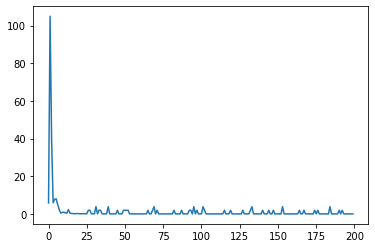

In [47]:
plt.plot(game_losses)

In [48]:
critic_value[0,0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.00063101074>

In [49]:
abs(result_value - critic_value)[0,0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.00063101074>

In [50]:
critic_value

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00063101]], dtype=float32)>

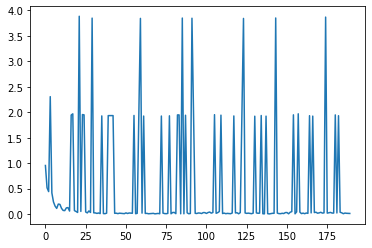

In [51]:
plt.plot(game_losses[10:])

In [52]:
# did it work?

In [53]:
#look at the board
board

array([24,  9, 51, 20, 50, 54, 27, 28, 41, 80, 26, 37])

In [54]:
#what does the model decide when given this board?
state = board_to_input(board)
choice_probs, critic_value = model(state)

In [55]:
choice_probs

<tf.Tensor: shape=(1, 12), dtype=float32, numpy=
array([[0.08345829, 0.0833939 , 0.0833997 , 0.08325356, 0.08337065,
        0.08324045, 0.08341904, 0.08339405, 0.08315274, 0.08334358,
        0.08320343, 0.08337051]], dtype=float32)>

In [56]:
# the critic's incorrectness isn't important enough. It looks like it is just settling on saying it'll fail every time.
# it is likely not seeing enough correct answers to learn to improve. Let it run for a while!

In [57]:
model(state)

[<tf.Tensor: shape=(1, 12), dtype=float32, numpy=
 array([[0.08345829, 0.0833939 , 0.0833997 , 0.08325356, 0.08337065,
         0.08324045, 0.08341904, 0.08339405, 0.08315274, 0.08334358,
         0.08320343, 0.08337051]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00046133]], dtype=float32)>]

In [58]:
result_value

0

In [59]:
abs(result_value - critic_value[0,0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.00046132703>

In [60]:
result_value

0

In [61]:
critic_value[0,0]

<tf.Tensor: shape=(), dtype=float32, numpy=-0.00046132703>

In [65]:
list(history)

[]

In [66]:
game_losses

[<tf.Tensor: shape=(), dtype=float32, numpy=5.822187>,
 <tf.Tensor: shape=(), dtype=float32, numpy=104.975525>,
 <tf.Tensor: shape=(), dtype=float32, numpy=39.48027>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.9510274>,
 <tf.Tensor: shape=(), dtype=float32, numpy=7.795615>,
 <tf.Tensor: shape=(), dtype=float32, numpy=7.9925566>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.871626>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.2458012>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.4318412>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.76738334>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.95272356>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5155296>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.44026038>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.304632>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.41429698>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.23759091>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.15572676>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.